In [889]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

import torch
import torchvision.transforms as transforms
from skimage.util import random_noise

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU, IoU
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError, F1Score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryFocalCrossentropy, CategoricalFocalCrossentropy


In [890]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [891]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [892]:
image_dataset_path = image_dest_path

In [893]:
# train and test dataset file paths
train_path =  os.path.join(downloads_path, "train_data.h5")
test_path =  os.path.join(downloads_path, "test_data.h5")

Loading Training and Testing datasets

In [894]:
# load train dataset
with h5py.File(train_path, 'r') as hf:
    X_train = hf['X'][:]
    y_train_mask = hf['y_mask'][:]
    y_train_class = hf['y_class'][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train_mask shape: {y_train_mask.shape}")
print(f"y_train_class shape: {y_train_class.shape}")

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)


In [895]:
# load test dataset
with h5py.File(test_path, 'r') as hf:
    X_test = hf['X'][:]
    y_test_mask = hf['y_mask'][:]
    y_test_class = hf['y_class'][:]

print(f"X_test shape: {X_test.shape}")
print(f"y_test_mask shape: {y_test_mask.shape}")
print(f"y_test_class shape: {y_test_class.shape}")

X_test shape: (392, 100, 100)
y_test_mask shape: (392, 100, 100)
y_test_class shape: (392, 7)


Initializing functions for deep learning model

In [915]:
################################
#           Focal loss         #
################################
@tf.function
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -tf.reduce_mean(alpha * tf.math.pow(1. - pt_1, gamma) * tf.math.log(pt_1+K.epsilon())) - tf.reduce_mean((1 - alpha) * tf.math.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed


In [916]:
# Register the function 
tf.keras.utils.get_custom_objects()['focal_loss_fixed'] = focal_loss_fixed

In [897]:
################################
#             Dice             #
################################
# Define the dice function

def DiceLoss(y_true, y_pred, smooth=1e-6):
    
    # if you are using this loss for multi-class segmentation then uncomment 
    # following lines
    # if y_pred.shape[-1] <= 1:
    #     # activate logits
    #     y_pred = tf.keras.activations.sigmoid(y_pred)
    # elif y_pred.shape[-1] >= 2:
    #     # activate logits
    #     y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
    #     # convert the tensor to one-hot for multi-class segmentation
    #     y_true = K.squeeze(y_true, 3)
    #     y_true = tf.cast(y_true, "int32")
    #     y_true = tf.one_hot(y_true, num_class, axis=-1)
    
    # cast to float32 datatype
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    
    # Flatten label and prediction tensors
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return 1 - dice

In [917]:
# Register the function 
tf.keras.utils.get_custom_objects()['DiceLoss'] = DiceLoss

In [898]:
class TimingCallback(Callback):
    def __init__(self, max_duration_seconds, logs={}):
        self.logs=[]
        self.max_duration_seconds = max_duration_seconds
            
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        total_duration = timer() - self.start_time
        if total_duration > self.max_duration_seconds:
            print(f"Stopping training after {total_duration / 3600} hours")
            self.model.stop_training = True


In [899]:
early_stopping = EarlyStopping(
                                patience=10, 
                                min_delta = 0.0001, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                        monitor="val_loss",
                                        patience=5, 
                                        min_delta= 0.0001,
                                        factor=0.1,  
                                        cooldown = 6, 
                                        verbose=1)

checkpoint = ModelCheckpoint(
                            'best_model_params_res_unet.keras', 
                            monitor='val_loss', 
                            verbose=1, 
                            #save_best_only=True, 
                            mode='min')


time_callback = TimingCallback(36000) # 36000 = 10 hrs, 18000 = 5 hrs, 7200 = 2 hrs

In [900]:
def elegant_res_unet_segmentation_classification(input_shape, num_classes): #Res-unet combo
   
    inputs = layers.Input(shape=input_shape)

    # RES part of model: residual skip connections
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        input_tensor_transformed = layers.Conv2D(num_filters, 1, activation=None, padding='same')(input_tensor)
        input_tensor_transformed = layers.BatchNormalization()(input_tensor_transformed)
        
        return layers.add([x, input_tensor_transformed])

    # Encoder contraction layers with residual skip connections
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.DepthwiseConv2D(3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 1, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', dilation_rate=2, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder expansion layers with residual skip connections
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = conv_block(up1, 128)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = conv_block(up2, 64)

    # Segmentation Output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Classification Head

    flatten = layers.GlobalAveragePooling2D()(conv3)
    dense1 = layers.Dense(256, activation='relu')(flatten)
    dropout1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(128, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout2)

    # Create Model
    model = models.Model(inputs=inputs, 
                         outputs=[segmentation_output, 
                                  classification_output
                                  ])
    return model

In [901]:
# extracting numer of classes information from dataset 
num_classes = y_train_class.shape[1]
print(num_classes)

7


In [902]:
# extracting input_shape information from dataset 
input_shape = np.expand_dims(X_train, axis=-1)
input_shape = input_shape.shape[1:]
print(input_shape)

(100, 100, 1)


In [903]:
# Instantiate the model
model = elegant_res_unet_segmentation_classification(input_shape=input_shape, num_classes=num_classes)

In [1090]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer='adam', #(learning_rate=0.0001)#optimizer,
    loss={
        'segmentation_output': 'binary_crossentropy', #focal_loss(alpha=.25, gamma=2),  # for the mask output with sigmoid 'binary_crossentropy', #
        'classification_output': 'categorical_crossentropy' #"categorical_focal_crossentropy"  # for the classification output with softmax
    },
    loss_weights={
        'segmentation_output': 0.9,  # initially Weighted at 80%, 20%
        'classification_output': 0.1  # initially Weighted at 20%, 80%
    },
    metrics={
        'segmentation_output': ['accuracy', MeanAbsoluteError(), MeanIoU(num_classes=num_classes)],  # Metrics for segmentation IoU(num_classes=num_classes, target_class_ids=[0,1,2,3,4,5,6])
        'classification_output': ['accuracy', Recall(), Precision()]  # Metrics for classification
    }
)

In [905]:
model.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_462 (Conv2D) │ (None, 100, 100,  │        640 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_462[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_463 (Conv2D) │ (None, 100, 100,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_464 (Conv2D) │ (None, 100, 100,  │        128 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_463[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_464[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_132 (Add)       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 50, 50,    │          0 │ add_132[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_465 (Conv2D) │ (None, 50, 50,    │     73,856 │ max_pooling2d_66… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_465[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_466 (Conv2D) │ (None, 50, 50,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_467 (Conv2D) │ (None, 50, 50,    │      8,320 │ max_pooling2d_66… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_466[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_467[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_133 (Add)       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 25, 25,    │          0 │ add_133[0][0]   

 Total params: 1,757,192 (6.70 MB)

 Trainable params: 1,753,608 (6.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [906]:
plot_model(model, to_file='elegant_res_unet_segmentation_classification.png', show_shapes=True, show_layer_names=True)

In [907]:
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_mask.shape)
print("y_train_class shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_mask shape:", y_test_mask.shape)
print("y_test_class shape:", y_test_class.shape)

print("Expected input shape for the model:", model.input_shape)
print("Model output shape:", model.output_shape)

print("Data type of y_train_class:", y_train_class.dtype)

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)
X_test shape: (392, 100, 100)
y_test_mask shape: (392, 100, 100)
y_test_class shape: (392, 7)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: [(None, 100, 100, 1), (None, 7)]
Data type of y_train_class: float64


In [985]:
total_epochs = 5

In [1091]:
# Train the model
history = model.fit(x=X_train, 
                    y=[y_train_mask, y_train_class],
                    epochs=total_epochs,
                    batch_size=32,
                    validation_data=(X_test, [y_test_mask, y_test_class]),
                    callbacks=[ reduce_learning_rate, 
                                #early_stopping, 
                                checkpoint
                                #time_callback
                                ],
                    verbose=True)

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - classification_output_accuracy: 0.9863 - classification_output_precision_42: 0.9880 - classification_output_recall_42: 0.9848 - loss: 0.0533 - segmentation_output_accuracy: 0.9805 - segmentation_output_mean_absolute_error: 0.0298 - segmentation_output_mean_io_u_42: 0.4691
Epoch 1: saving model to best_model_params_res_unet.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 1497s 4s/step - classification_output_accuracy: 0.9864 - classification_output_precision_42: 0.9880 - classification_output_recall_42: 0.9848 - loss: 0.0533 - segmentation_output_accuracy: 0.9805 - segmentation_output_mean_absolute_error: 0.0298 - segmentation_output_mean_io_u_42: 0.4691 - val_classification_output_accuracy: 0.9209 - val_classification_output_precision_42: 0.9349 - val_classification_output_recall_42: 0.9158 - val_loss: 0.0931 - val_segmentation_output_accuracy: 0.9764 - val_segmentation_output_mean_absolute_error: 0.0310 - val_segmentation_output_mean_io_u_42: 0.4

In [1455]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_enhanced_res_unet_3.csv', index=False)
model.save('model_enhanced_res_unet_3.keras')

In [1093]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc_seg = history.history["segmentation_output_accuracy"]
val_acc_seg = history.history["val_segmentation_output_accuracy"]

train_acc_class = history.history["classification_output_accuracy"]
val_acc_class = history.history["val_classification_output_accuracy"]

train_precision_class = history.history["classification_output_precision_42"]
val_precision_class = history.history["val_classification_output_precision_42"]

train_recall_class = history.history["classification_output_recall_42"]
val_recall_class = history.history["val_classification_output_recall_42"]

train_mae = history.history["segmentation_output_mean_absolute_error"]
val_mae = history.history["val_segmentation_output_mean_absolute_error"]

train_mean_iou = history.history["segmentation_output_mean_io_u_42"]
val_mean_iou = history.history["val_segmentation_output_mean_io_u_42"]


#segmentation_output_weights = history.history['segmentation_output_weight']
#classification_output_weights = history.history['classification_output_weight']


In [1094]:
train_classification_f1_score =[]
val_classification_f1_score = []
for i in range(len(train_precision_class)):
    x1 = 2 * (train_precision_class[i] * train_recall_class[i]) / (train_precision_class[i] + train_recall_class[i] + 0.000001)
    x2 = 2 * (val_precision_class[i] * val_recall_class[i]) / (val_precision_class[i] + val_recall_class[i] + 0.000001)
    train_classification_f1_score.append(x1)
    val_classification_f1_score.append(x2)

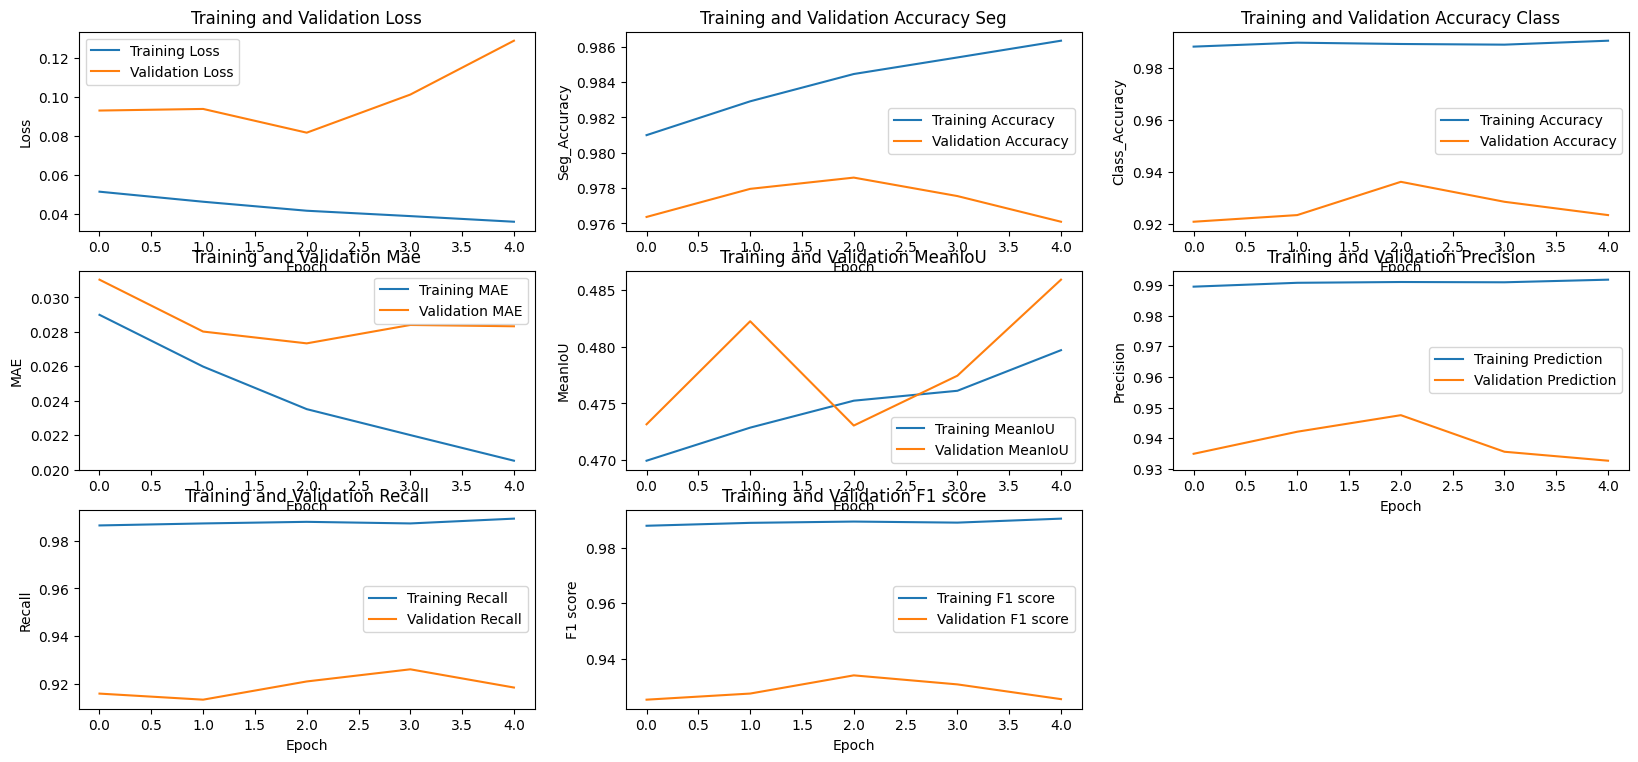

In [1095]:
plt.figure(figsize = (20, 15))

plt.subplot(531)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(532)
plt.plot(train_acc_seg, label="Training Accuracy")
plt.plot(val_acc_seg, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Seg_Accuracy")
plt.title("Training and Validation Accuracy Seg")
plt.legend()

plt.subplot(533)
plt.plot(train_acc_class, label="Training Accuracy")
plt.plot(val_acc_class, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Class_Accuracy")
plt.title("Training and Validation Accuracy Class")
plt.legend()

plt.subplot(534)
plt.plot(train_mae, label="Training MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation Mae")
plt.legend()

plt.subplot(535)
plt.plot(train_mean_iou, label="Training MeanIoU")
plt.plot(val_mean_iou, label="Validation MeanIoU")
plt.xlabel("Epoch")
plt.ylabel("MeanIoU")
plt.title("Training and Validation MeanIoU")
plt.legend()

plt.subplot(536)
plt.plot(train_precision_class, label="Training Prediction")
plt.plot(val_precision_class, label="Validation Prediction")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(537)
plt.plot(train_recall_class, label="Training Recall")
plt.plot(val_recall_class, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(538)
plt.plot(train_classification_f1_score, label="Training F1 score")
plt.plot(val_classification_f1_score, label="Validation F1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Training and Validation F1 score")
plt.legend()


plt.show()



In [1096]:
y_mask_pred, y_class_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


In [1097]:
predicted_labels = np.argmax(y_class_pred, axis=1)

test_labels = np.argmax(y_test_class, axis=1)


class_labels_pred = {
    0: 'missing_hole',
    1: 'mouse_bite',
    2: 'none',
    3: 'open_circuit',
    4: 'short',
    5: 'spur',
    6: 'spurious_copper'
}

remapped_labels = [class_labels_pred[label] for label in predicted_labels]

remapped_test_labels = [class_labels_pred[label] for label in test_labels]


In [1098]:
print(len(y_class_pred))

392


In [1099]:
output_probabilities = np.array(y_class_pred[0])
confidence = np.max(output_probabilities)
predicted_class = np.argmax(output_probabilities)
print(confidence)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}")

0.9982803
Predicted Class: 1
Confidence: 0.9982802867889404


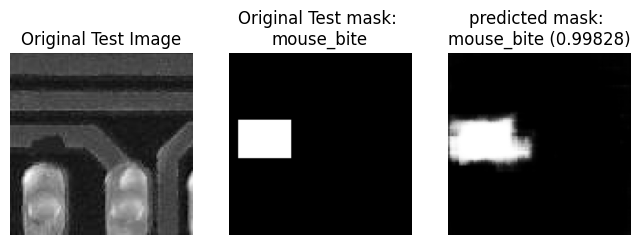

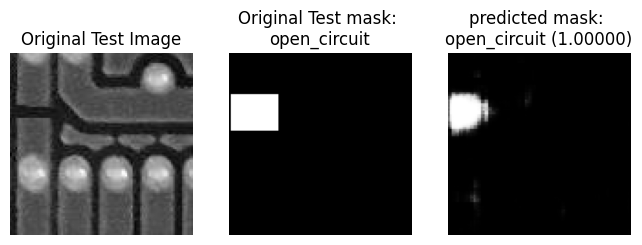

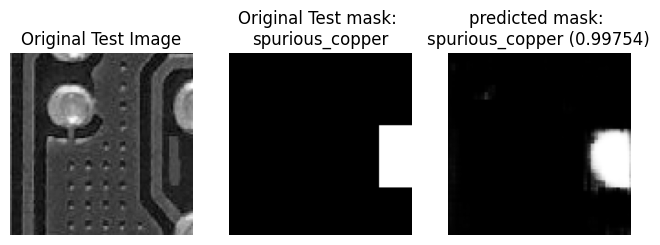

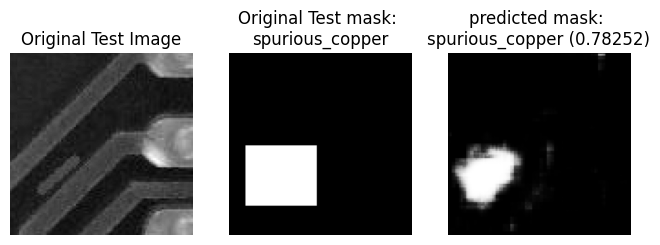

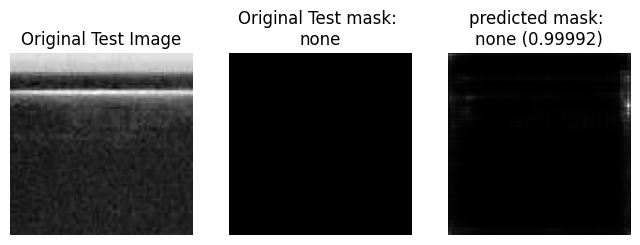

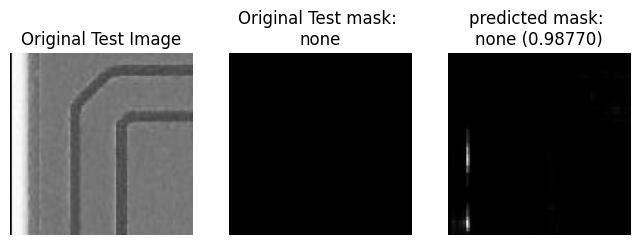

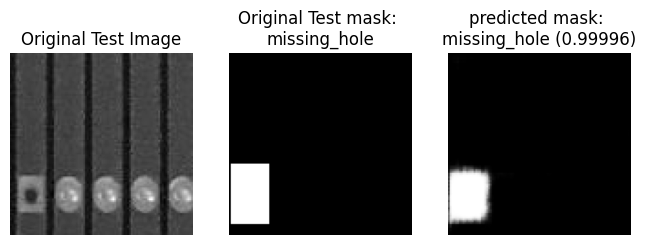

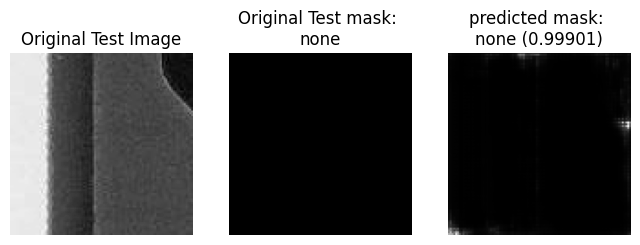

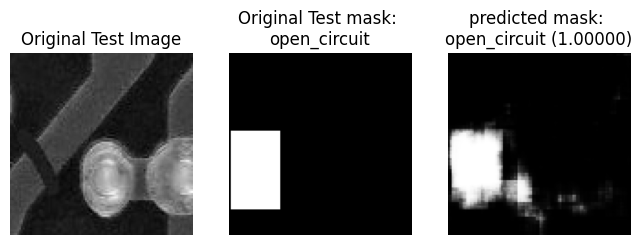

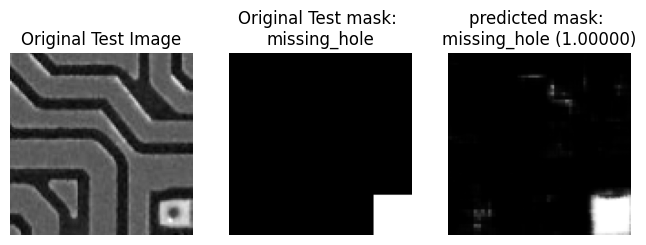

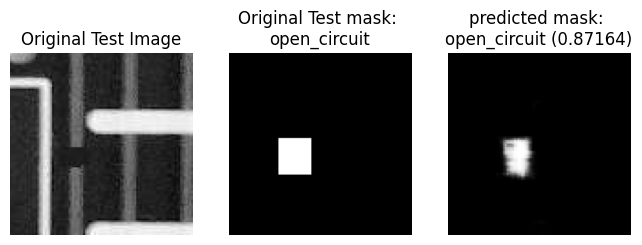

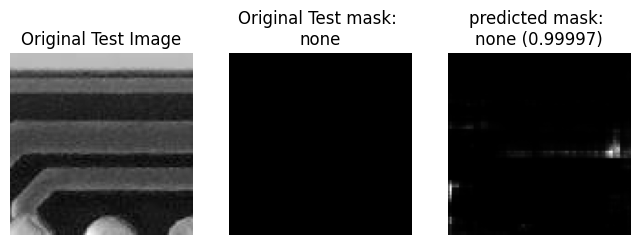

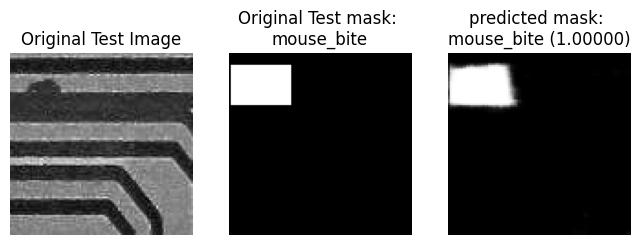

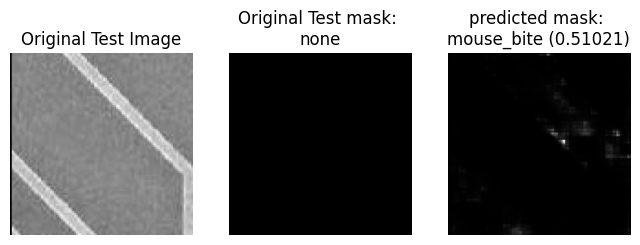

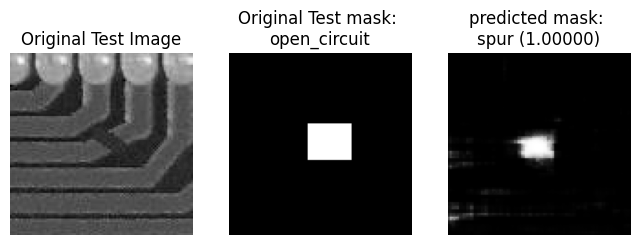

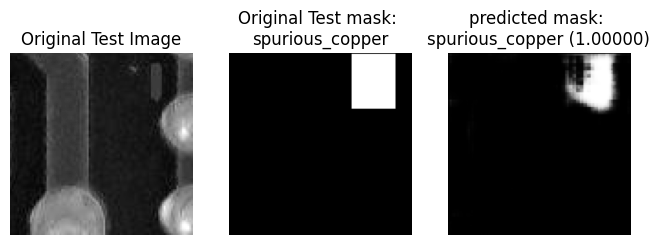

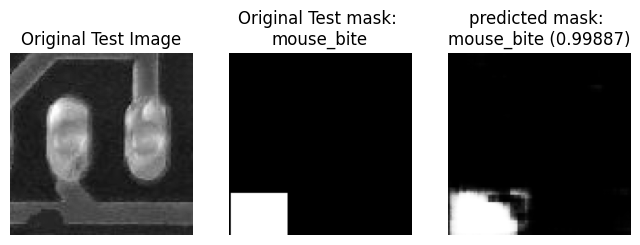

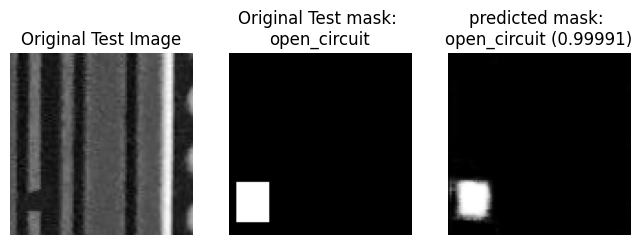

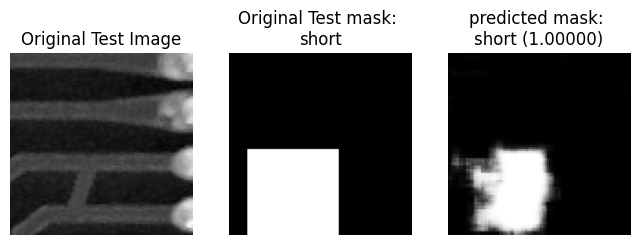

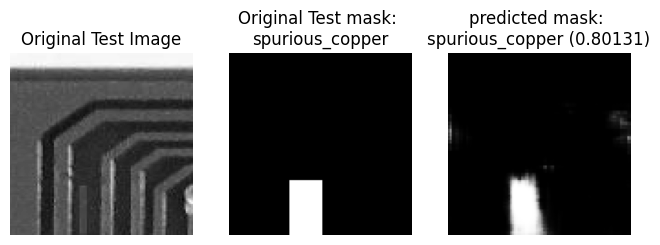

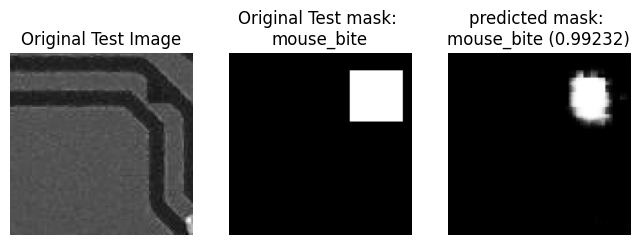

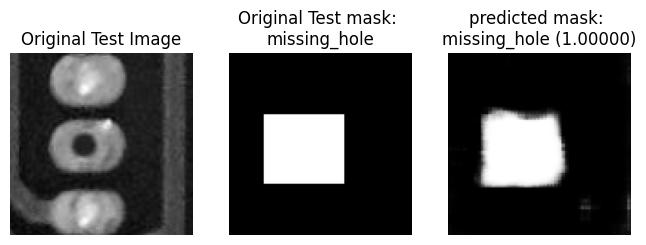

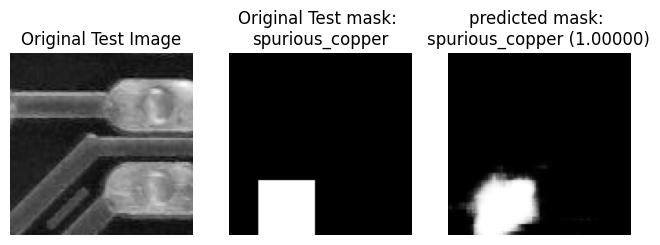

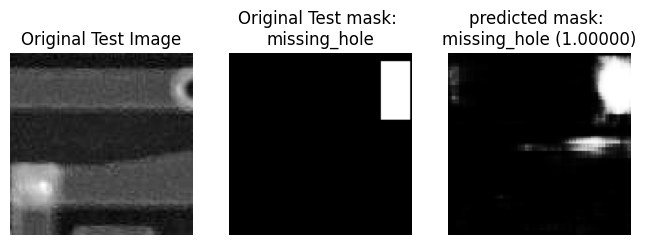

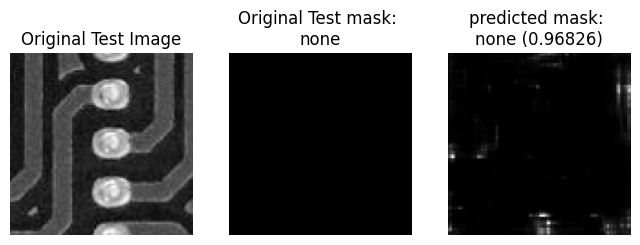

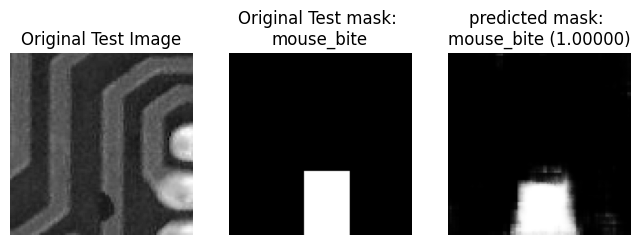

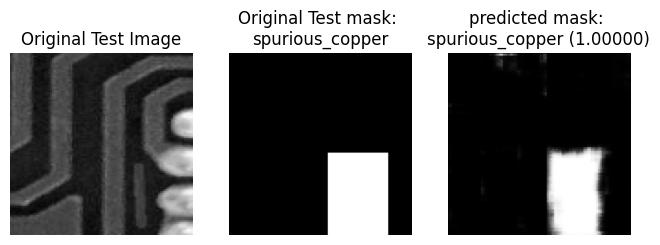

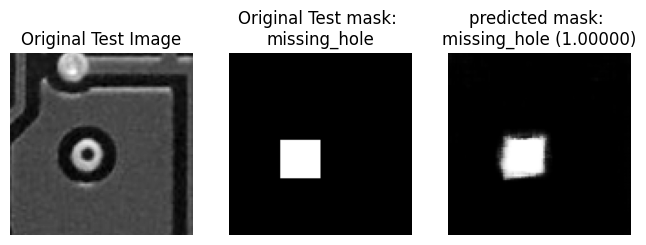

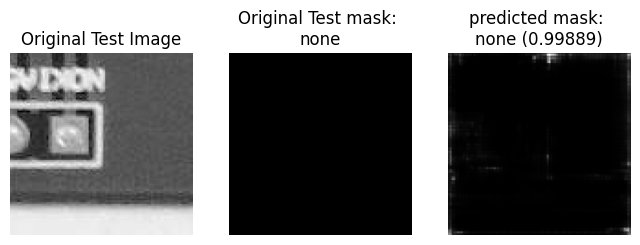

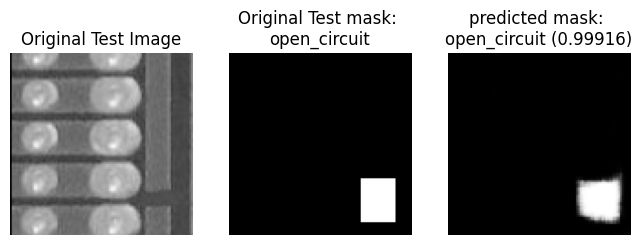

In [1100]:

for i in range(0,30,1):
    output_probabilities = np.array(y_class_pred[i])
    confidence = np.max(output_probabilities)

      
    plt.figure(figsize = (8, 5))
    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_mask[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + remapped_test_labels[i])
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_mask_pred[i].squeeze(), cmap='gray')  
    plt.title(f'predicted mask: \n{remapped_labels[i]} ({confidence:.5f})')
    plt.axis('off')

    plt.show()
    



In [1101]:
# Create a DataFrame for the true and predicted labels
df = pd.DataFrame({'True_Labels': remapped_test_labels, 'Predicted_Labels': remapped_labels})

# Create a crosstab
crosstab = pd.crosstab(df['Predicted_Labels'], df['True_Labels'])

print(crosstab)

True_Labels       missing_hole  mouse_bite  none  open_circuit  short  spur  \
Predicted_Labels                                                              
missing_hole                57           0     0             0      0     0   
mouse_bite                   0          46     4             1      0     2   
none                         0           2    60             0      3     8   
open_circuit                 0           1     0            45      0     0   
short                        0           0     0             0     47     0   
spur                         0           1     1             1      2    46   
spurious_copper              0           0     1             0      0     0   

True_Labels       spurious_copper  
Predicted_Labels                   
missing_hole                    0  
mouse_bite                      0  
none                            1  
open_circuit                    0  
short                           0  
spur                            2  


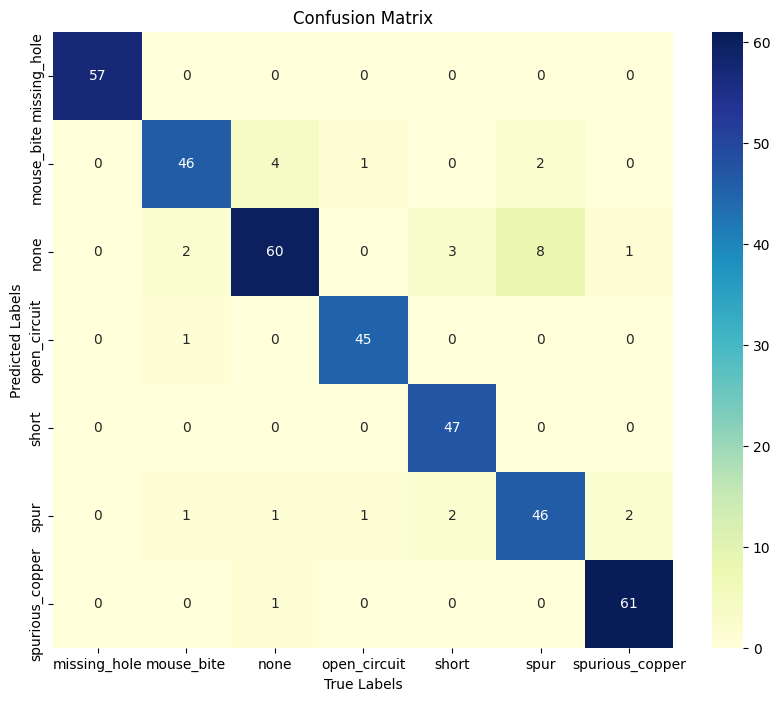

In [1102]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [1103]:
missing_hole_indices = np.where(predicted_labels == 5)[0]  # Get the indices directly
# Get the corresponding predicted masks for missing_hole predictions
missing_hole_masks = y_mask_pred[missing_hole_indices]
missing_hole_labels = np.array(remapped_labels)[missing_hole_indices]
print(len(missing_hole_indices))
print(missing_hole_indices)

'''
# Print the predicted masks  
for i in range(len(missing_hole_indices)):
    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + missing_hole_labels[i])
    plt.axis('off')
    
    plt.show()
    '''

53
[ 14  46  48  50  54  58  62  68  76  86  90 105 108 116 118 132 140 154
 157 164 168 179 193 195 196 197 204 207 208 211 216 233 238 242 245 250
 256 262 269 276 281 290 299 304 316 318 326 332 336 344 347 371 376]


"\n# Print the predicted masks  \nfor i in range(len(missing_hole_indices)):\n    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') \n    plt.title('Original Test mask: \n' + missing_hole_labels[i])\n    plt.axis('off')\n    \n    plt.show()\n    "

In [1104]:
image_test2 = []
gray_image2 = []
#image_test2 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_11_spur_02_5_600.jpg')
image_test2 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg')

image_test2 = cv2.resize(image_test2, (600, 600)) 
gray_image2 = cv2.cvtColor(image_test2, cv2.COLOR_BGR2GRAY)
image_array_test2 = np.asarray(gray_image2) / 255.0 

In [1105]:
image_array_test2 = np.expand_dims(image_array_test2, axis=0)  # Add batch dimension
y_pred2, y_class2 = model.predict(image_array_test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 344s 344s/step


In [1106]:
print(y_class2)
predicted_label2 = np.argmax(y_class2, axis=1)
remapped_label2 = [class_labels_pred[label] for label in predicted_label2]

# Print the remapped labels
print("Remapped Labels:", remapped_label2)

[[5.3017711e-08 4.3517788e-04 9.9718297e-01 8.0981306e-05 2.7434035e-07
  2.2848947e-03 1.5737180e-05]]
Remapped Labels: ['none']


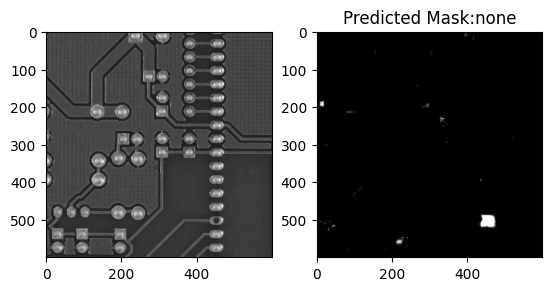

In [1107]:

plt.subplot(121) 
plt.imshow(gray_image2.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred2.squeeze(), cmap='gray')
plt.title('Predicted Mask:' +remapped_label2[0])
plt.show()

In [1589]:
image_test3 = []
gray_image3 = []
mask_test3 = []
gray_mask3 = []

image_test3 = cv2.imread('C:/Users/wfaiz/OneDrive/Documents/GitHub/PCB_Defects_Detection/data/Images/l_light_07_short_08_5_600.jpg')
mask_test3 = cv2.imread('C:/Users/wfaiz/OneDrive/Documents/GitHub/PCB_Defects_Detection/data/Pixel_masks/pm-l_light_07_short_08_5_600.png')

image_test3 = cv2.resize(image_test3, (600, 600))  # Resize
gray_image3 = cv2.cvtColor(image_test3, cv2.COLOR_BGR2GRAY)
image_array_test3 = np.asarray(gray_image3) / 255.0 #normalize

mask_test3 = cv2.resize(mask_test3, (600, 600))  # Resize
gray_mask3 = cv2.cvtColor(mask_test3, cv2.COLOR_BGR2GRAY)
mask_array_test3 = np.asarray(gray_mask3) / 255.0 #normalize


In [1590]:
def crop_image(image, crop_size=(300, 300)):
    crops = []
    #print(image.shape)
    height, width = image.shape
    crop_height, crop_width = crop_size

    for i in range(0, height, crop_height):
        for j in range(0, width, crop_width):
            crop = image[i:i + crop_height, j:j + crop_width]
            if crop.shape[0] == crop_height and crop.shape[1] == crop_width:
                crops.append(crop)
    return crops

# Crop the normalized grayscale image into 100x100 sections
crops = np.asarray(crop_image(image_array_test3, crop_size=(300, 300)))


In [1591]:
#print(X_test.shape)
print(crops.shape)

(4, 300, 300)


In [1592]:
y_pred3, y_class3 = model.predict(crops)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


In [1593]:
print(y_class3)
predicted_label3 = np.argmax(y_class3, axis=1)
remapped_label3 = [class_labels_pred[label] for label in predicted_label3]

# Print the remapped labels
print("Remapped Labels:", remapped_label3)

[[8.4283180e-05 1.8616587e-04 9.9090004e-01 1.2252609e-04 6.8446496e-03
  4.1060141e-04 1.4516979e-03]
 [1.4263074e-04 1.0531032e-04 7.7040009e-02 4.6955251e-05 9.2189336e-01
  2.2759096e-04 5.4415257e-04]
 [1.2066703e-06 2.6995980e-05 9.9954957e-01 2.1623493e-05 8.6482296e-06
  3.8451813e-05 3.5345909e-04]
 [4.6973508e-07 1.2312166e-05 9.9979347e-01 1.1187672e-05 3.2426300e-07
  1.0298430e-05 1.7186685e-04]]
Remapped Labels: ['none', 'short', 'none', 'none']


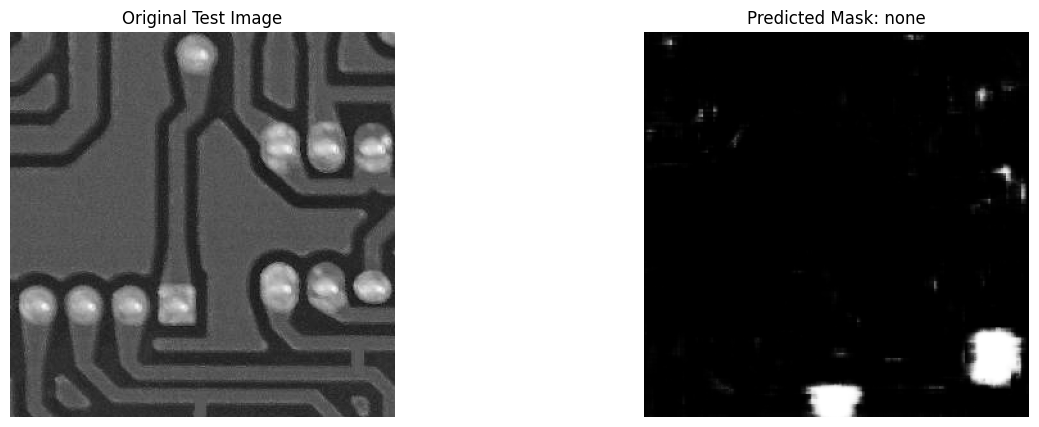

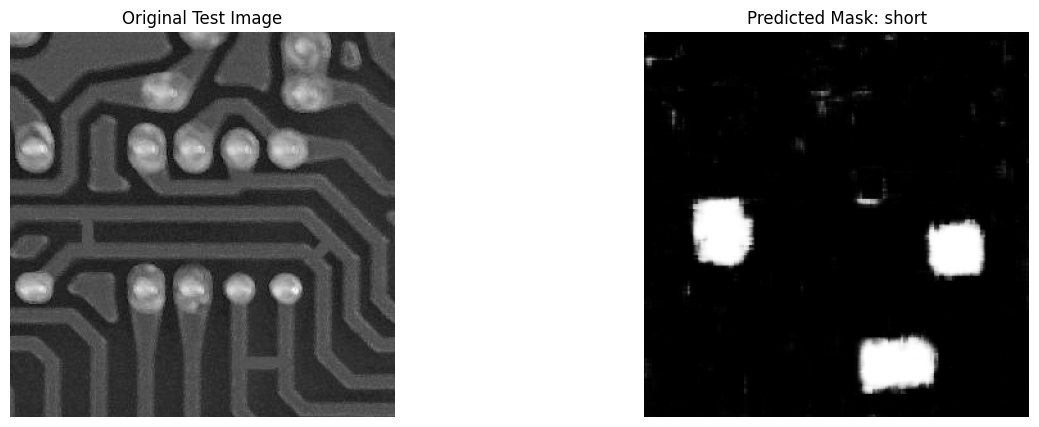

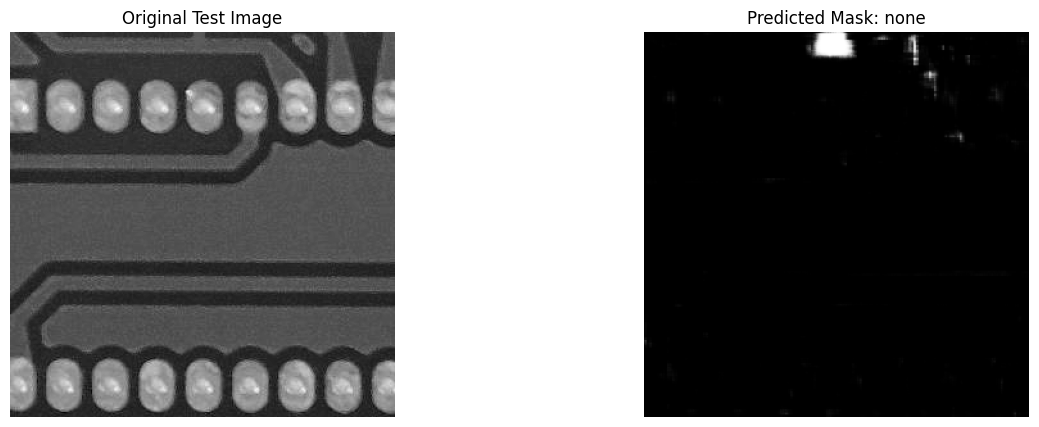

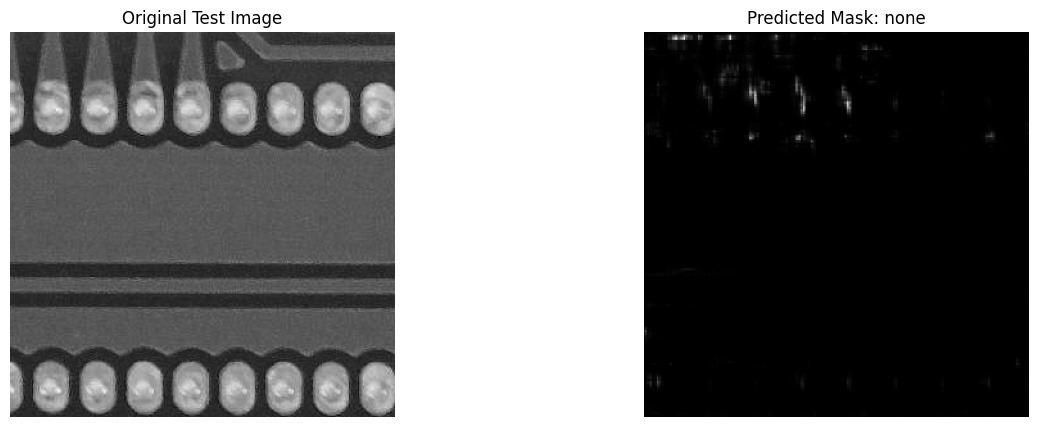

In [1594]:
number_of_crops = crops.shape[0]
for i in range(number_of_crops):

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(crops[i], cmap='gray')
    plt.title('Original Test Image')
    plt.axis('off')


    plt.subplot(122)
    plt.imshow(y_pred3[i], cmap='gray')
    plt.title('Predicted Mask: ' +remapped_label3[i])
    plt.axis('off')

    plt.show()

In [1595]:
def combine_crops(crops, crop_size=(300, 300), full_size=(600, 600)):
    rows = full_size[0] // crop_size[0]
    cols = full_size[1] // crop_size[1]
    combined_image = np.zeros(full_size)

    crop_idx = 0
    for i in range(rows):
        for j in range(cols):
            combined_image[i*crop_size[0]:(i+1)*crop_size[0], j*crop_size[1]:(j+1)*crop_size[1]] = crops[crop_idx]
            crop_idx += 1
    return combined_image

In [1596]:
X_test_combined = combine_crops(crops)
#y_test_mask_combined = combine_crops(y_pred3.squeeze())
y_mask_pred_combined = combine_crops(y_pred3.squeeze())



In [1597]:
output_image_path = 'C:/Users/wfaiz/OneDrive/Desktop/y_mask_pred_combined.png'

# Save the image
cv2.imwrite(output_image_path, y_mask_pred_combined)

True

In [1598]:
crop_idx = 0
class_test = []
for i in range(0, 600, 100):
    for j in range(0, 600, 100):
        #if y_class3.squeeze()[crop_idx] != 'none':
        class_test.append(y_class3)
        crop_idx += 1

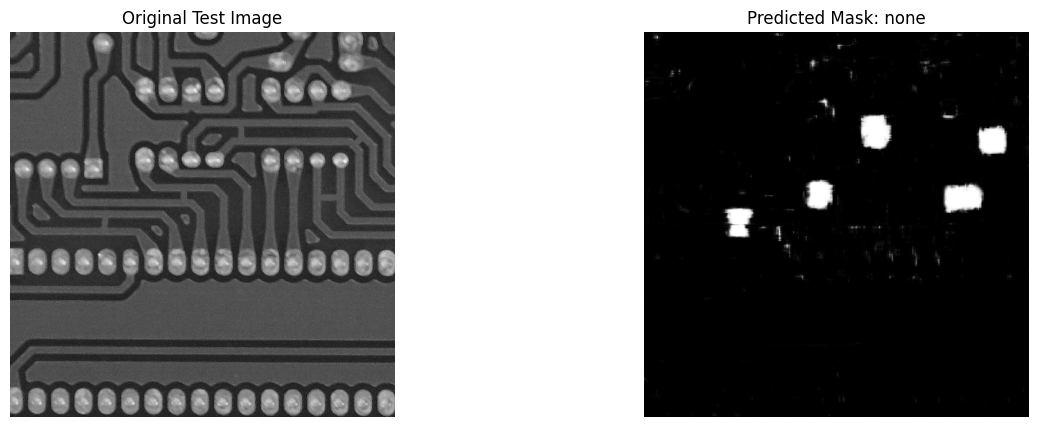

In [1599]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(X_test_combined, cmap='gray')
plt.title('Original Test Image')
plt.axis('off')


plt.subplot(122)
plt.imshow(y_mask_pred_combined, cmap='gray')
plt.title('Predicted Mask: ' +remapped_label3[0])
plt.axis('off')

plt.show()

The predicted masks need to be cropped and then the new class prediction made on it to make sure the correct class prediction is achieved.
This is because the model was designed for 100,100 image size but while predicting we want to predict dynamically.

In [1600]:
# Preprocessing
def preprocess_image(image):
    # Apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = np.array(blurred, dtype=np.uint8)
    # Use Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure the binary image is of type uint8
    thresh = np.array(thresh, dtype=np.uint8)

    # Apply morphological operations to remove small noise
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    return thresh


In [1601]:
# Detect and filter contours based on area
def detect_and_filter_contours(binary_image, min_contour_area):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]
    bounding_boxes = []
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    return filtered_contours, bounding_boxes

In [1602]:
# Draw contours and bounding boxes on the image
def draw_contours(image, contours):
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for color drawing
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        print(x, y, w, h)
        cv2.drawContours(output_image, [contour], -1, 255, -1)
        cv2.rectangle(output_image, (x, y), (x + w, y + h), 255, -1)
    return output_image

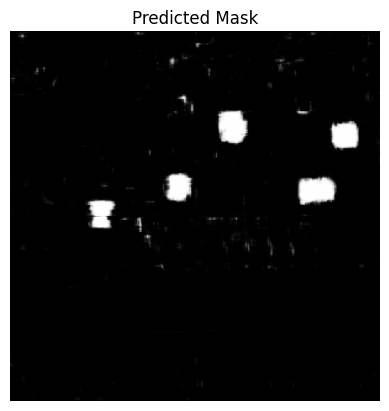

uint8
float64


In [1603]:
normalized_image = cv2.normalize(y_mask_pred_combined, 5, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    # Convert to uint8
normalized_image = np.uint8(normalized_image)
        #y_mask_pred_combined = np.uint8(y_mask_pred_combined)

plt.imshow(normalized_image, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()
print(normalized_image.dtype)
print(y_mask_pred_combined.dtype)


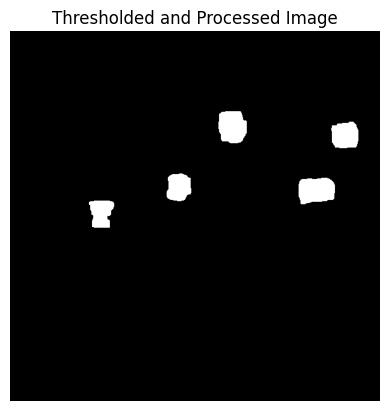

Number of contours found: 5
128 275 41 44
468 238 59 43
254 231 40 45
521 147 44 43
338 130 46 52


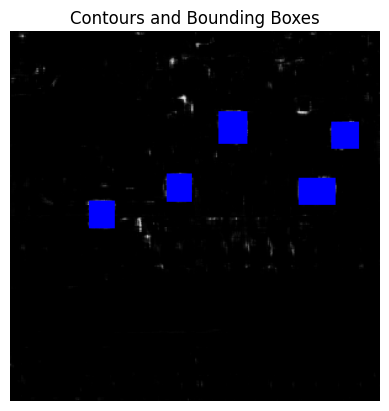

In [1604]:

# Preprocess the image
thresh = preprocess_image(normalized_image)

# Display the thresholded and morphologically processed image
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded and Processed Image")
plt.axis('off')
plt.show()

# Detect and filter contours
min_contour_area = 100  # Adjust this threshold based on your requirements
filtered_contours, bounding_boxes = detect_and_filter_contours(thresh, min_contour_area)

# Check the number of contours found
print("Number of contours found:", len(filtered_contours))

# Draw contours and bounding boxes
output_image = draw_contours(normalized_image, filtered_contours)

# Display the image with contours and bounding boxes
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Contours and Bounding Boxes")
plt.axis('off')
plt.show()

In [1605]:
def crop_and_resize_images(image, bounding_boxes, size=(100, 100)):
    cropped_images = []
    
    for bbox in bounding_boxes:
        print("Bounding Box:", bbox)
        x, y, w, h = bbox
        
        cx = x + w // 2
        cy = y + h // 2
        
        print("Center:", cx, cy)
        
        start_x = max(0, cx - size[0] // 2)
        start_y = max(0, cy - size[1] // 2)
        
        print("Start Point:", start_x, start_y)
        
        start_x = min(start_x, image.shape[1] - size[0])
        start_y = min(start_y, image.shape[0] - size[1])
        
        print("Adjusted Start Point:", start_x, start_y)
        
        end_x = start_x + size[0]
        end_y = start_y + size[1]
        
        print("End Point:", end_x, end_y)
        
        cropped = image[start_y:end_y, start_x:end_x]
        
        print("Cropped Shape:", cropped.shape)
        
        cropped_resized = cv2.resize(cropped, size, interpolation=cv2.INTER_LINEAR)
        
        print("Resized Shape:", cropped_resized.shape)
        
        cropped_images.append(cropped_resized)
    
    return cropped_images

In [1606]:
cropped_images = crop_and_resize_images(X_test_combined, bounding_boxes)

Bounding Box: (128, 275, 41, 44)
Center: 148 297
Start Point: 98 247
Adjusted Start Point: 98 247
End Point: 198 347
Cropped Shape: (100, 100)
Resized Shape: (100, 100)
Bounding Box: (468, 238, 59, 43)
Center: 497 259
Start Point: 447 209
Adjusted Start Point: 447 209
End Point: 547 309
Cropped Shape: (100, 100)
Resized Shape: (100, 100)
Bounding Box: (254, 231, 40, 45)
Center: 274 253
Start Point: 224 203
Adjusted Start Point: 224 203
End Point: 324 303
Cropped Shape: (100, 100)
Resized Shape: (100, 100)
Bounding Box: (521, 147, 44, 43)
Center: 543 168
Start Point: 493 118
Adjusted Start Point: 493 118
End Point: 593 218
Cropped Shape: (100, 100)
Resized Shape: (100, 100)
Bounding Box: (338, 130, 46, 52)
Center: 361 156
Start Point: 311 106
Adjusted Start Point: 311 106
End Point: 411 206
Cropped Shape: (100, 100)
Resized Shape: (100, 100)


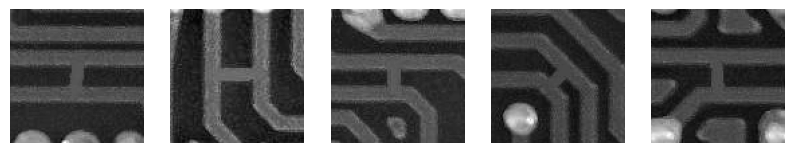

In [1607]:
num_images = len(cropped_images)
fig, axs = plt.subplots(1, num_images, figsize=(10, 10))

for i in range(num_images):
    axs[i].imshow(cropped_images[i], cmap='gray') 
    axs[i].axis('off')

plt.show()

In [1608]:
#test
cropped_images_batch = np.expand_dims(cropped_images[1], axis=0)
y_pred4, y_class4 = model.predict(cropped_images_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Remapped Labels for image 0: ['short']


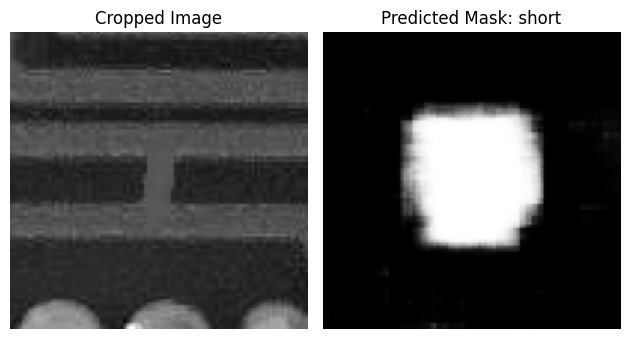

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Remapped Labels for image 1: ['short']


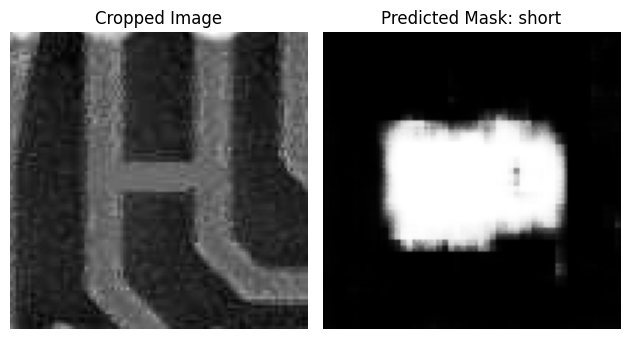

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Remapped Labels for image 2: ['short']


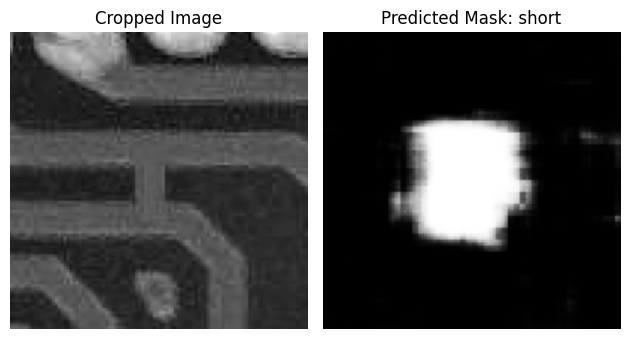

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Remapped Labels for image 3: ['short']


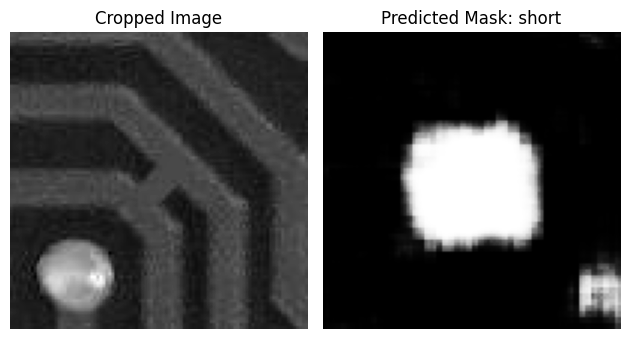

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Remapped Labels for image 4: ['short']


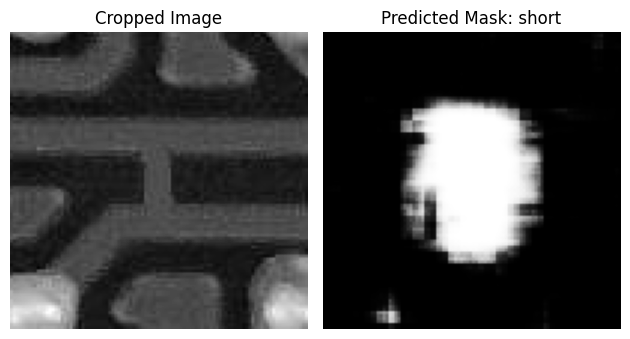

In [1609]:
y_mask_pred = []
y_class_pred = []
pred_label = []
remapped_pred_label = []

for i in range(num_images):
    cropped_image = cropped_images[i]
    cropped_image = np.expand_dims(cropped_image, axis=0)  # Add batch dimension
    #cropped_images_batch = np.expand_dims(cropped_images[i], axis=0)
    #print(cropped_images_batch.shape)
    y_mask_pred_i, y_class_pred_i = model.predict(cropped_image)

    y_mask_pred.append(y_mask_pred_i)
    y_class_pred.append(y_class_pred_i)

    pred_label_i = np.argmax(y_class_pred_i, axis=1)
    remapped_pred_label_i = [class_labels_pred[label] for label in pred_label_i]

    pred_label.append(pred_label_i)
    remapped_pred_label.append(remapped_pred_label_i)

    # Testprint
    print(f"Remapped Labels for image {i}: {remapped_pred_label_i}")

    plt.subplot(121) 
    plt.imshow(cropped_image.squeeze(), cmap='gray')
    plt.title('Cropped Image')
    plt.axis('off')

    plt.subplot(122) 
    plt.imshow(y_mask_pred_i.squeeze(), cmap='gray')
    plt.title(f'Predicted Mask: {remapped_pred_label_i[0]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
                            

In [1610]:
normalized_image = cv2.normalize(y_mask_pred_combined, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_image = np.uint8(normalized_image)
thresh = preprocess_image(normalized_image)

# Detect contours and bounding boxes
min_contour_area = 100
filtered_contours, bounding_boxes = detect_and_filter_contours(thresh, min_contour_area)


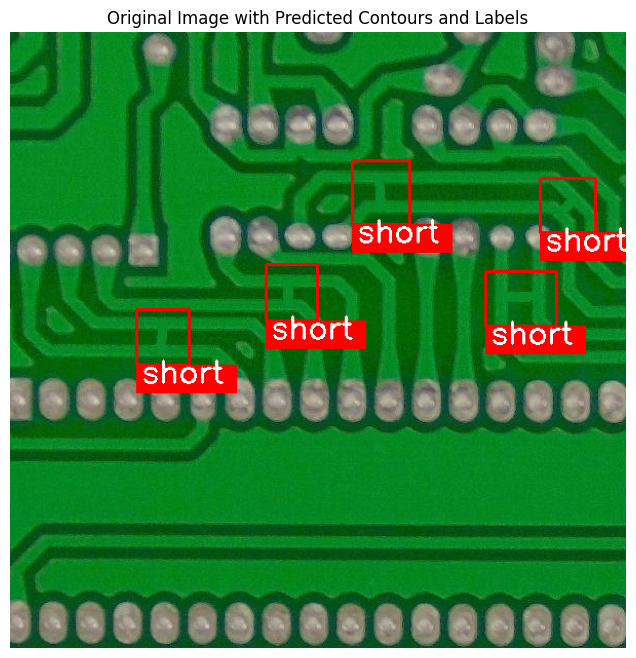

In [1615]:

# Draw contours and bounding boxes on the original image_test3
output_image = image_test3.copy()  # Make a copy of the original image
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

for contour, bbox, label in zip(filtered_contours, bounding_boxes, remapped_pred_label):
    x, y, w, h = bbox

    cv2.rectangle(output_image, (x - 5, y - 5), (x + w + 5, y + h + 5), (255, 0, 0), 2)

    text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
    text_bg_size = (text_size[0] + 10, text_size[1] + 10)

    #cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  # Draw contour
    #cv2.rectangle(image, (xmin, ymax), (xmin + text_bg_size[0], ymax + text_bg_size[1]), color, -1)
    cv2.rectangle(output_image, (x - 5, y + h + 5), (x + text_bg_size[0], y + h + text_bg_size[1]), (255, 0, 0), -1)  # Draw bounding box
    #draw_bboxes_with_class(image_gt, gt_bboxes, gt_class_ids, color=(0, 255, 0))
    class_label = label[0]

    # Put text (class label) above the bounding box
    cv2.putText(output_image, str(class_label), (x, y + h + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    #cv2.putText(image, class_name, (xmin + 5, ymax + text_size[1] + 5), font, font_scale, (255, 255, 255), thickness)

# Display the image with overlaid contours and bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.title('Original Image with Predicted Contours and Labels')
plt.axis('off')
plt.show()

In [1616]:
normalized_image2 = cv2.normalize(mask_array_test3, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_image2 = np.uint8(normalized_image2)
thresh2 = preprocess_image(normalized_image2)

# Detect contours and bounding boxes
min_contour_area = 100
filtered_contours2, bounding_boxes2 = detect_and_filter_contours(thresh2, min_contour_area)


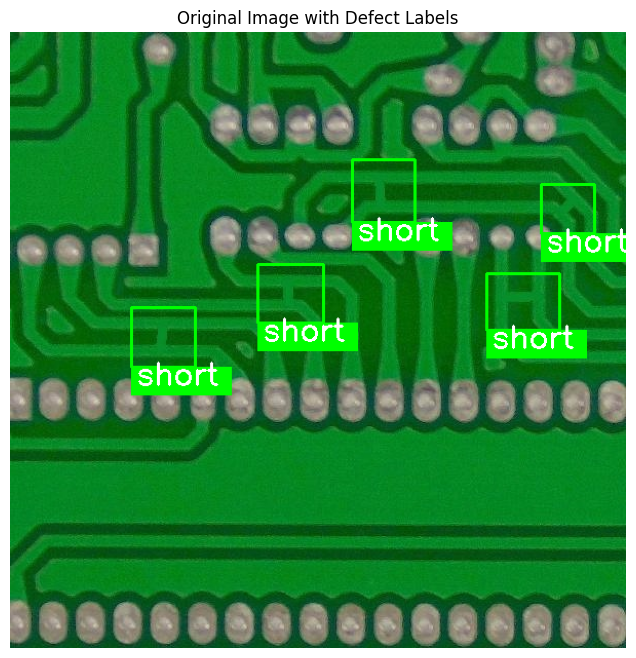

In [1618]:
# Draw contours and bounding boxes on the original image_test3
output_image2 = image_test3.copy()  # Make a copy of the original image
output_image2 = cv2.cvtColor(output_image2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
label_test = 'short' # doing this manually for now. will automate later
for contour, bbox, label in zip(filtered_contours2, bounding_boxes2, label_test):
    x, y, w, h = bbox

    cv2.rectangle(output_image2, (x - 5, y - 5), (x + w + 5, y + h + 5), (0, 255, 0), 2)

    text_size = cv2.getTextSize(label_test, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
    text_bg_size = (text_size[0] + 10, text_size[1] + 10)

    #cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  # Draw contour
    #cv2.rectangle(image, (xmin, ymax), (xmin + text_bg_size[0], ymax + text_bg_size[1]), color, -1)
    cv2.rectangle(output_image2, (x - 5, y + h + 5), (x + text_bg_size[0], y + text_bg_size[1] + h), (0, 255, 0), -1)  # Draw bounding box
    #draw_bboxes_with_class(image_gt, gt_bboxes, gt_class_ids, color=(0, 255, 0))
    class_label = label_test

    # Put text (class label) above the bounding box
    cv2.putText(output_image2, str(class_label), (x, y + text_size[1] + h), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    #cv2.putText(image, class_name, (xmin + 5, ymax + text_size[1] + 5), font, font_scale, (255, 255, 255), thickness)

# Display the image with overlaid contours and bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(output_image2)
plt.title('Original Image with Defect Labels')
plt.axis('off')
plt.show()

In [1619]:
# getting bboxes from contours
def get_bbox(image, bboxes, class_ids, color=(0, 255, 0), thickness=2, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1):
    normalized_image = cv2.normalize(y_mask_pred_combined, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.uint8(normalized_image)
    thresh = preprocess_image(normalized_image)

    # Detect contours and bounding boxes
    min_contour_area = 100
    filtered_contours, bounding_boxes = detect_and_filter_contours(thresh, min_contour_area)


In [1620]:
# draw bounding boxes on the image
def draw_bboxes_with_class(image, bboxes, class_ids, color=(0, 255, 0), thickness=2, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1):
    for contour, bbox, label in zip(filtered_contours, bounding_boxes, remapped_pred_label):
        x, y, w, h = bbox

        cv2.rectangle(output_image, (x - 5, y - 5), (x + w + 5, y + h + 5), color, thickness)

        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_bg_size = (text_size[0] + 10, text_size[1] + 10)

        #cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  # Draw contour
        #cv2.rectangle(image, (xmin, ymax), (xmin + text_bg_size[0], ymax + text_bg_size[1]), color, -1)
        cv2.rectangle(output_image, (x - 5, y + h + 5), (x + text_bg_size[0], y + text_bg_size[1] + 25), color, -1)  # Draw bounding box
        #draw_bboxes_with_class(image_gt, gt_bboxes, gt_class_ids, color=(0, 255, 0))
        class_label = label[0]

        # Put text (class label) above the bounding box
        cv2.putText(output_image, str(class_label), (x, y + text_size[1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness)

    return output_image

In [1621]:
# display original and result images side by side
def display_images_side_by_side(images, titles=None, figsize=(20, 20)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles:
            ax.set_title(title)
        ax.axis('off')
    plt.show()

In [ ]:
draw_bboxes_with_class(output_image, gt_bboxes, gt_class_ids, color=(0, 255, 0))

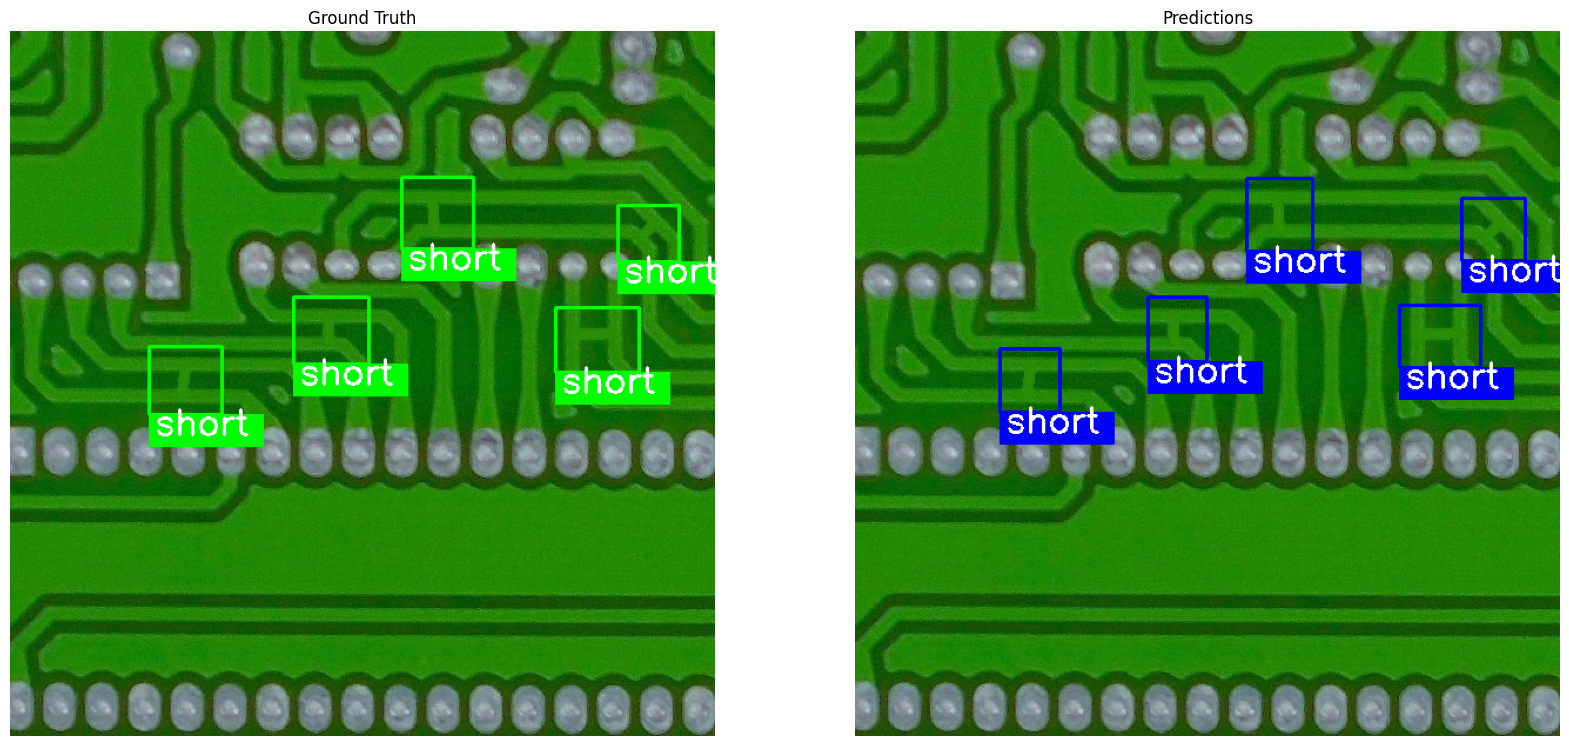

In [1622]:
display_images_side_by_side([output_image2, output_image], titles=['Ground Truth', 'Predictions'])

In [1011]:
# Load the model from a file if needed for further training
from tensorflow.keras.models import load_model
model_path = 'model_enhanced_res_unet_3.keras'
'''
custom_objects = {
    #'focal_loss_fixed': focal_loss_fixed,
    #'DiceLoss': DiceLoss,
    'BinaryFocalCrossentropy': BinaryFocalCrossentropy,
    'CategoricalFocalCrossentropy': CategoricalFocalCrossentropy
}
'''
#model = load_model(model_path)#, custom_objects=custom_objects)

model = load_model(model_path, custom_objects={
    'MeanAbsoluteError': MeanAbsoluteError,
    'MeanIoU': MeanIoU,
    'Recall': Recall,
    'Precision': Precision
})